# Paper from BioInfo Club: 
"Plasma proteomics reveals tissue-specific cell death and mediators of cell-cell interactions in severe COVID-19 patients", Filbin et.al., https://pubmed.ncbi.nlm.nih.gov/33173871/

In [30]:
# general imports to support logic below
#
# data wrangling
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy.stats import mannwhitneyu
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import chi2


# Get the data files from the paper:
source: https://www.olink.com/mgh-covid-study/

There are/were 3 data files:

In [2]:
# File Names
myNpxFile = "MGH_COVID_OLINK_NPX.txt"
myInfoFile = "MGH_COVID_Clinical_Info.txt"
myVarDescFile = "variable_descriptions.xlsx"

# TWO SCENARIOS: 
* Option 1: google colab / google drive
* Option 2: running locally with local copy of data

# Option 1: You are running on google colab/ google drive
Run these commands if running from Google colab / google drive
Skip this block if you have downloaded the data to run locally


I previously did these steps (one time):
*   downloaded the 3 data files from  to my home PC
*   uploaded the 3 data files to my google drive
*   used the 'share links' functionality from Google drive in chrome browser to find the 3 file IDs below


In [ ]:
# source:https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/
#
# !pip install pydrive
# !pip install google-colab
#
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
#
# may need to follow link to open google SDK authentication in browser and copy/paste a token
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#
# share links:
# https://drive.google.com/file/d/1z_SJEiPpCVKnqnFsicqdxYd3rahppURj/view?usp=sharing
# https://drive.google.com/file/d/1eN5_fikV_jLMW6vd_9Hu6vpmrOpIhBMF/view?usp=sharing
# https://drive.google.com/file/d/1fuYNNtUxF7DhaDT6AXZZ9DGRunfCb6aH/view?usp=sharing
# 
# FileIDs
myNpxFileId = "1z_SJEiPpCVKnqnFsicqdxYd3rahppURj"
myInfoFileId = "1eN5_fikV_jLMW6vd_9Hu6vpmrOpIhBMF"
myVarDescFileId = "1fuYNNtUxF7DhaDT6AXZZ9DGRunfCb6aH"


In [ ]:
# instantiate/pull/populate NPX data file
downloadedNpx = drive.CreateFile({'id':myNpxFileId}) 
downloadedNpx.GetContentFile(myNpxFile) 
dataNpx = pd.read_csv(myNpxFile,delimiter=";")

In [ ]:
# load clinical info file
downloadedInfo = drive.CreateFile({'id':myInfoFileId})   
downloadedInfo.GetContentFile(myInfoFile) 
dataInfo = pd.read_csv(myInfoFile,delimiter=";")

In [ ]:
# load variable description xlsx file
downloadedVarDesc = drive.CreateFile({'id':myVarDescFileId})   
downloadedVarDesc.GetContentFile(myVarDescFile) 
dataVarDesc = pd.read_excel(myVarDescFile)

# Option 2: You are running with a local copy of the data
Run these commands if running with a local copy of the data

Assumes you have original data in 'raw/olink_data' subdirectory.  
NOTE: data is ';' delimited.

In [3]:
myFilePath = "olink_data/raw/"
dataNpx = pd.read_csv(myFilePath + myNpxFile,delimiter=";")

In [4]:
dataInfo = pd.read_csv(myFilePath + myInfoFile,delimiter=";")

In [14]:
# !pip install openpyxl
from openpyxl import load_workbook
# TODO: remove this (hack due to sharing issue on windows 10)
myVarDescFile = "variable_descriptions2.xlsx"
myFullVarPath = myFilePath + myVarDescFile
print("myFullVarPath: ",myFullVarPath)
xl = pd.ExcelFile(myFullVarPath)
print(xl.sheet_names)
dataVarDesc = xl.parse(xl.sheet_names[0])
dataVarDesc.head()

myFullVarPath:  olink_data/raw/variable_descriptions2.xlsx
['variable descriptions']


,Variable,Description
0,subject_id,Subject ID
1,COVID,COVID status (tested positive prior to enrollment or during hospitalization) 0 = negative 1= positive
2,Age cat,Age category 1 = 20-34 2 = 36-49 3 = 50-64 4 = 65-79 5 = 80+
3,BMI cat,Body mass index: 0 = <18.5 (underweight) 1 = 18.5-24.9 (normal) 2 = 25.0-29.9 (overweight) 3 = 30.0-39.9 (obese) 4 = >=40 (severely obese) 5 = Unknown
4,HEART,"Pre-existing heart disease – HEART - (coronary artery disease, congestive heart failure, valvular disease) 0 = No 1 = Yes"


# Initial exploration of the data

In [15]:
# initial exploration of the the NPX data 
print("# elements: ",dataNpx.size)
print("dimensions: ")
print("    rows: ", dataNpx.shape[0])
print("    cols: ", dataNpx.shape[1])
print("column names and datatypes: ")
for index, value in dataNpx.dtypes.items():
  print("    ", index, " : ", value)
dataNpx.head()
dataNpx.describe()

# elements:  16084824
dimensions: 
    rows:  1148916
    cols:  14
column names and datatypes: 
     SampleID  :  object
     subject_id  :  float64
     Timepoint  :  object
     Index  :  int64
     OlinkID  :  object
     UniProt  :  object
     Assay  :  object
     MissingFreq  :  float64
     Panel  :  object
     Panel_Version  :  int64
     PlateID  :  object
     LOD  :  float64
     NPX  :  float64


,subject_id,Index,MissingFreq,Panel_Version,LOD,NPX
count,1.120336e+06,1.148916e+06,1.148916e+06,1148916.0,1.148916e+06,1.148898e+06
mean,1.973839e+02,4.598383e+01,2.133310e-01,1.0,8.087463e-01,2.934964e+00
std,1.137254e+02,2.742623e+01,3.021994e-01,0.0,8.008172e-01,2.084241e+00
min,1.000000e+00,1.000000e+00,3.000000e-02,1.0,-1.056700e+00,-7.512100e+00
25%,9.800000e+01,2.200000e+01,3.000000e-02,1.0,3.159000e-01,1.270100e+00
50%,1.970000e+02,4.500000e+01,4.000000e-02,1.0,6.776000e-01,2.747600e+00
75%,3.000000e+02,6.900000e+01,2.500000e-01,1.0,1.098800e+00,4.361200e+00
max,3.860000e+02,9.400000e+01,9.900000e-01,1.0,5.826600e+00,1.572680e+01


In [16]:
# initial exploration of the clinical info data 
print("# elements: ",dataInfo.size)
print("dimensions: ")
print("    rows: ", dataInfo.shape[0])
print("    cols: ", dataInfo.shape[1])
print("column names and datatypes: ")
for index, value in dataInfo.dtypes.items():
  print("    ", index, " : ", value)
dataInfo.head()
dataInfo.describe()

# elements:  15360
dimensions: 
    rows:  384
    cols:  40
column names and datatypes: 
     subject_id  :  int64
     COVID  :  int64
     Age cat  :  int64
     BMI cat  :  int64
     HEART  :  int64
     LUNG  :  int64
     KIDNEY  :  int64
     DIABETES  :  int64
     HTN  :  int64
     IMMUNO  :  int64
     Resp_Symp  :  int64
     Fever_Sympt  :  int64
     GI_Symp  :  int64
     WHO 0  :  int64
     WHO 3  :  int64
     WHO 7  :  int64
     WHO 28  :  int64
     WHO max  :  int64
     abs_neut_0_cat  :  float64
     abs_lymph_0_cat  :  float64
     abs_mono_0_cat  :  float64
     creat_0_cat  :  float64
     crp_0_cat  :  float64
     ddimer_0_cat  :  float64
     ldh_0_cat  :  float64
     Trop_72h  :  int64
     abs_neut_3_cat  :  float64
     abs_lymph_3_cat  :  float64
     abs_mono_3_cat  :  float64
     creat_3_cat  :  float64
     crp_3_cat  :  float64
     ddimer_3_cat  :  float64
     ldh_3_cat  :  float64
     abs_neut_7_cat  :  float64
     abs_lymph_7_cat  :  float

,subject_id,COVID,Age cat,BMI cat,HEART,LUNG,KIDNEY,DIABETES,HTN,IMMUNO,...,crp_3_cat,ddimer_3_cat,ldh_3_cat,abs_neut_7_cat,abs_lymph_7_cat,abs_mono_7_cat,creat_7_cat,crp_7_cat,ddimer_7_cat,ldh_7_cat
count,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,...,228.000000,209.000000,193.000000,179.000000,178.000000,178.000000,191.000000,144.000000,133.000000,115.000000
mean,193.330729,0.796875,3.218750,2.479167,0.184896,0.276042,0.158854,0.361979,0.518229,0.109375,...,3.390351,2.894737,2.834197,3.039106,3.044944,3.084270,2.094241,3.215278,3.428571,2.834783
std,111.795820,0.402850,1.206623,1.151493,0.388720,0.447621,0.366017,0.481200,0.500319,0.312516,...,1.317886,1.018304,1.209111,0.863512,1.229672,1.270562,1.214612,1.364706,1.102928,1.025383
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,96.750000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,2.000000
50%,193.500000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000
75%,290.250000,1.000000,4.000000,3.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,3.000000
max,386.000000,1.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [17]:
pd.options.display.max_colwidth = 400
display(dataVarDesc)
dataVarDesc.head()

,Variable,Description
0,subject_id,Subject ID
1,COVID,COVID status (tested positive prior to enrollment or during hospitalization) 0 = negative 1= positive
2,Age cat,Age category 1 = 20-34 2 = 36-49 3 = 50-64 4 = 65-79 5 = 80+
3,BMI cat,Body mass index: 0 = <18.5 (underweight) 1 = 18.5-24.9 (normal) 2 = 25.0-29.9 (overweight) 3 = 30.0-39.9 (obese) 4 = >=40 (severely obese) 5 = Unknown
4,HEART,"Pre-existing heart disease – HEART - (coronary artery disease, congestive heart failure, valvular disease) 0 = No 1 = Yes"
5,LUNG,"Pre-existing lung disease – LUNG - (asthma, COPD, requiring home O2, any chronic lung condition) 0 = No 1 = Yes"
6,KIDNEY,"Pre-existing kidney disease – KIDNEY - (chronic kidney disease, baseline creatinine >1.5, ESRD) 0 = No 1 = Yes"
7,DIABETES,"Pre-existing diabetes – DIABETES - (pre-diabetes, insulin and non-insulin dependent diabetes) 0 = No 1 = Yes"
8,HTN,Pre-existing hypertension - HTN 0 = No 1 = Yes
9,IMMUNO,"Pre-existing immunocompromised condition – IMMUNO (active cancer, chemotherapy, transplant, immunosuppressant agents, aspenic) 0 = No 1 = Yes"


,Variable,Description
0,subject_id,Subject ID
1,COVID,COVID status (tested positive prior to enrollment or during hospitalization) 0 = negative 1= positive
2,Age cat,Age category 1 = 20-34 2 = 36-49 3 = 50-64 4 = 65-79 5 = 80+
3,BMI cat,Body mass index: 0 = <18.5 (underweight) 1 = 18.5-24.9 (normal) 2 = 25.0-29.9 (overweight) 3 = 30.0-39.9 (obese) 4 = >=40 (severely obese) 5 = Unknown
4,HEART,"Pre-existing heart disease – HEART - (coronary artery disease, congestive heart failure, valvular disease) 0 = No 1 = Yes"


some observations:
* 'subject_id' is a unique key specifying a patient
* there are 384 patients, leading to 384 rows of 'clinical info' for each of the 384 subjects
* rows in 'NPX' data are the time series data points.
* each row is the normalized protein expression ('NPX' column) for a time series data point ('Timepoint' column) for a specific protein ('UniProt' column) for a specific patient ('subject_id' column)

Issues/questions:
* 'subject_id' column in the NPX data frame is a float data type but it is an integer in the clinical info data frame. TODO: cast the column to integer so we can join across frames
* what is 'LOD' column in the NPX data frame?
* there are NaNs (missing data) to deal with

Notes/questions from paper:
* NPX values for scaled to (mean,sdev) ~ (0,1)
* outliers windsorized (unclear if 4 or 5 sdevs, presumably before scaling)
* How did they deal with missing data?
* 'Supplemental Table(s) #'...??? what tables?
* 'Extended Data Figure(s) #'...?  what extended data figures?


# Figure 1A statistics
* Info data set
* feature 'COVID' = 1 => confirmed covid case
* 'Acuity_max' is bucketing data based on 'WHO_max' feature

In [18]:
# 'Acuity max within 28d' for patients confirmed with COVID:
# ASSUME: feature is 'WHO max' with mapping (inferred from 'Results' section, page 3 and above feature descriptions):
#     WHO max      'Accuity max within 28 days'
#      1               A1
#      2               A2
#      3 & 4           A3
#      5               A4
#      6               A5
covidPositivePatients = dataInfo.loc[dataInfo['COVID']==1]
numCovidPositivePatients = len(covidPositivePatients)
print("# of patients confirmed with COVID: ", numCovidPositivePatients)
accuityMaxBins = covidPositivePatients.groupby(['WHO max'])
print("# of accuity max outcomes seen: ", len(accuityMaxBins))
uniqueAccuityMax = covidPositivePatients['WHO max'].unique()
uniqueAccuityMax.sort()
print("bin covid positive patients by accuity max:")
for val in uniqueAccuityMax:
  numVal = len(covidPositivePatients.loc[covidPositivePatients['WHO max']==val])
  print("WHO max = ",val,": ", numVal, " cases ({:.1f}".format(100*numVal/numCovidPositivePatients)," %}")

# of patients confirmed with COVID:  306
# of accuity max outcomes seen:  5
bin covid positive patients by accuity max:
WHO max =  1 :  42  cases (13.7  %}
WHO max =  2 :  67  cases (21.9  %}
WHO max =  4 :  133  cases (43.5  %}
WHO max =  5 :  36  cases (11.8  %}
WHO max =  6 :  28  cases (9.2  %}


Comments on above: 
* NOTE there is no 'WHO max' = 3 in the data.  I *think* WHO max = 4 is 'A3' in the paper
* 'A4' and 'A5' in the paper are *close* to 'WHO max' = 5 and 'WHO max' = 6, respectively but not identical (41 vs 36 and 23 vs 28, respectively - WHY the difference??  snip from paper below:

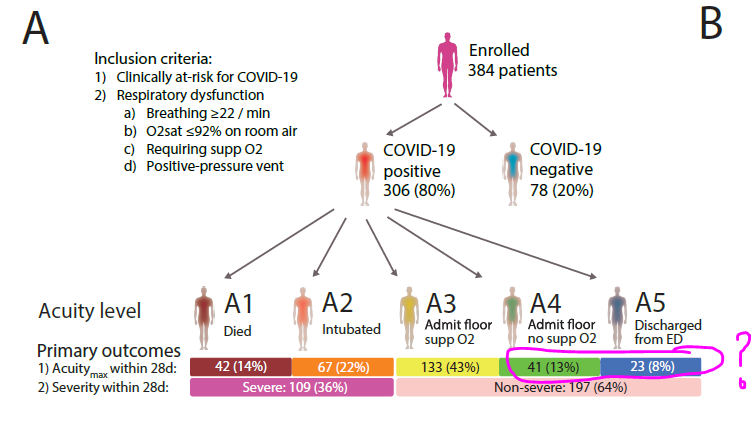


# Extended Data Figure 1: patient counts by age
binning the data by 'count' of patients (ordinate) vs feature (e.g. age) vs covid positive or negative (color)
NOTE: the publicly available data only has 'Age_cat' with 5 bins while the 'Extended Figures' have more detailed information

In [19]:
#OLD   # cut by age using pandas function
#OLD   print("unique age categories: ", dataInfo['Age cat'].unique())
#OLD   dataInfo.hist(column='Age cat',by='COVID')

positives: 
     Age cat  =  1 :  32  cases (10.5  %}
     Age cat  =  2 :  66  cases (21.6  %}
     Age cat  =  3 :  89  cases (29.1  %}
     Age cat  =  4 :  65  cases (21.2  %}
     Age cat  =  5 :  54  cases (17.6  %}
negatives: 
     Age cat  =  1 :  4  cases (5.1  %}
     Age cat  =  2 :  7  cases (9.0  %}
     Age cat  =  3 :  22  cases (28.2  %}
     Age cat  =  4 :  34  cases (43.6  %}
     Age cat  =  5 :  11  cases (14.1  %}


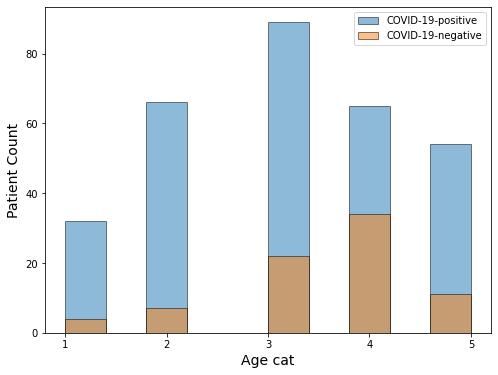

In [21]:
# compare the data by overlaying histograms using matplotlib functionality:
feature = "Age cat"
uniqueVals = dataInfo[feature].unique()
uniqueVals.sort()
# numBins = len(uniqueVals)
positives = dataInfo.loc[dataInfo['COVID']==1]
negatives = dataInfo.loc[dataInfo['COVID']==0]
numPos = len(positives)
numNeg = len(negatives)
# trim the data
dataPos = positives[feature]
dataNeg = negatives[feature]
print("positives: ")
for val in uniqueVals:
  numVal = len(positives.loc[positives[feature]==val])
  print("    ", feature," = ",val,": ", numVal, " cases ({:.1f}".format(100*numVal/numPos)," %}")
print("negatives: ")
for val in uniqueVals:
  numVal = len(negatives.loc[negatives[feature]==val])
  print("    ", feature," = ",val,": ", numVal, " cases ({:.1f}".format(100*numVal/numNeg)," %}")

# plot the data
plt.figure(figsize=(8,6))
plt.hist(dataPos, alpha=0.5, label="COVID-19-positive", ec='black')
plt.hist(dataNeg, alpha=0.5, label="COVID-19-negative", ec='black')
plt.xlabel(feature, size=14)
plt.ylabel("Patient Count", size=14)
plt.xticks(uniqueVals)
plt.legend(loc='upper right')


In [22]:
# significance test:    H0: populations are identical
# MWU statistic test to see if two samples are from the same population
stat, ppp = mannwhitneyu(dataPos, dataNeg)
print('MWU Statistics=%.3f, p=%.3f' % (stat, ppp))
# interpret w 95% confidence
alpha = 0.05
if ppp > alpha:
	print('Statistically SAME distribution (fail to reject H0)')
else:
	print('Statistically different distributions (reject H0)')

MWU Statistics=9682.000, p=0.004
Statistically different distributions (reject H0)


NOTE: The p value above is different then reported in their 'Extended Data Figure 1' - but - we are using coarser age data (only 5 categories asot ~30).  The statistical conclusion is the same:  splitting on Covit positives vs negatives looks like samples from two different populations.

# Extended Data Figure 1: patients by 'WHO 0' (Acuity @ Day 0)
this figure presents count of patients (ordinate) vs feature 'WHO 0' split by covid positive or negative (color)
Recall 'WHO 0' = 5 & 6 map to Acuity 'A4' & 'A5', respectively.

positives: 
     WHO 0  =  2 :  79  cases (25.8  %}
     WHO 0  =  4 :  152  cases (49.7  %}
     WHO 0  =  5 :  46  cases (15.0  %}
     WHO 0  =  6 :  29  cases (9.5  %}
negatives: 
     WHO 0  =  2 :  19  cases (24.4  %}
     WHO 0  =  4 :  35  cases (44.9  %}
     WHO 0  =  5 :  15  cases (19.2  %}
     WHO 0  =  6 :  9  cases (11.5  %}


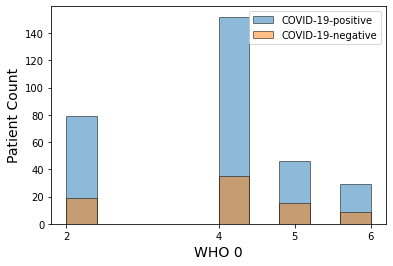

In [24]:
# patient counts by accuity on day 0
feature = "WHO 0"
uniqueVals = dataInfo[feature].unique()
uniqueVals.sort()
positives = dataInfo.loc[dataInfo['COVID']==1]
negatives = dataInfo.loc[dataInfo['COVID']==0]
numPos = len(positives)
numNeg = len(negatives)
# trim the data
dataPos = positives[feature]
dataNeg = negatives[feature]
print("positives: ")
for val in uniqueVals:
  numVal = len(positives.loc[positives[feature]==val])
  print("    ", feature," = ",val,": ", numVal, " cases ({:.1f}".format(100*numVal/numPos)," %}")
print("negatives: ")
for val in uniqueVals:
  numVal = len(negatives.loc[negatives[feature]==val])
  print("    ", feature," = ",val,": ", numVal, " cases ({:.1f}".format(100*numVal/numNeg)," %}")

# plot
plt.hist(dataPos, alpha=0.5, label="COVID-19-positive", ec='black')
plt.hist(dataNeg, alpha=0.5, label="COVID-19-negative", ec='black')
plt.xlabel(feature, size=14)
plt.ylabel("Patient Count", size=14)
plt.xticks(uniqueVals)
plt.legend(loc='upper right')

NOTE: the publicly available data only has 'WHO 0' has NO data but accuity 'A1' but it is present in their chart - WTF?    

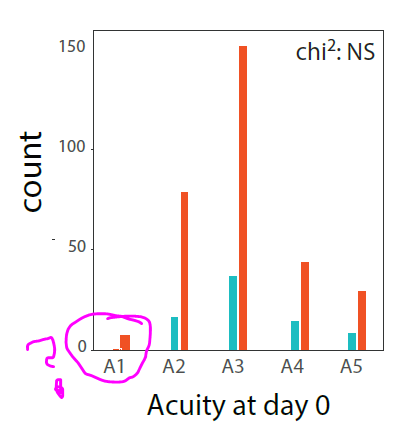


# Extended Data Figure 1: patients by 'WHO max' (Acuity max within 28 days)
this figure presents count of patients (ordinate) vs feature 'WHO 0' split by covid positive or negative (color)
Recall 'WHO 0' = 5 & 6 map to Acuity 'A4' & 'A5', respectively.

positives: 
     WHO max  =  1 :  42  cases (13.7  %}
     WHO max  =  2 :  67  cases (21.9  %}
     WHO max  =  4 :  133  cases (43.5  %}
     WHO max  =  5 :  36  cases (11.8  %}
     WHO max  =  6 :  28  cases (9.2  %}
negatives: 
     WHO max  =  1 :  7  cases (9.0  %}
     WHO max  =  2 :  16  cases (20.5  %}
     WHO max  =  4 :  34  cases (43.6  %}
     WHO max  =  5 :  12  cases (15.4  %}
     WHO max  =  6 :  9  cases (11.5  %}


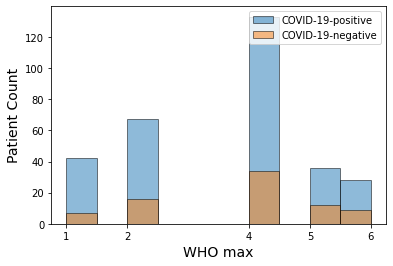

In [26]:
# patient counts by max acuity
feature = "WHO max"
uniqueVals = dataInfo[feature].unique()
uniqueVals.sort()
numBins = len(uniqueVals)
positives = dataInfo.loc[dataInfo['COVID']==1]
negatives = dataInfo.loc[dataInfo['COVID']==0]
numPos = len(positives)
numNeg = len(negatives)
# trim the data
dataPos = positives[feature]
dataNeg = negatives[feature]
print("positives: ")
for val in uniqueVals:
  numVal = len(positives.loc[positives[feature]==val])
  print("    ", feature," = ",val,": ", numVal, " cases ({:.1f}".format(100*numVal/numPos)," %}")
print("negatives: ")
for val in uniqueVals:
  numVal = len(negatives.loc[negatives[feature]==val])
  print("    ", feature," = ",val,": ", numVal, " cases ({:.1f}".format(100*numVal/numNeg)," %}")

# plot
plt.hist(dataPos, alpha=0.5, label="COVID-19-positive", ec='black')
plt.hist(dataNeg, alpha=0.5, label="COVID-19-negative", ec='black')
plt.xlabel(feature, size=14)
plt.ylabel("Patient Count", size=14)
plt.xticks(uniqueVals)
plt.legend(loc='upper right')

In [31]:
# UNTESTED!!!
#
# Chi^2 significance test for dependence/indepence for categorical variables
# source: https://machinelearningmastery.com/chi-squared-test-for-machine-learning/
#
# build contingency table between Covid +/- and WHO max:
feature1 = 'WHO max'
feature2 = 'COVID'
data_crosstab = pd.crosstab(dataInfo[feature1], 
                            dataInfo[feature2],  
                               margins = False) 
print(data_crosstab)
stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
    
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')


COVID     0    1
WHO max         
1         7   42
2        16   67
4        34  133
5        12   36
6         9   28
dof=4
[[  9.953125  39.046875]
 [ 16.859375  66.140625]
 [ 33.921875 133.078125]
 [  9.75      38.25    ]
 [  7.515625  29.484375]]
probability=0.950, critical=9.488, stat=2.174
Independent (fail to reject H0)
significance=0.050, p=0.704
Independent (fail to reject H0)


#Figure 1E - DDX58 NPX box plot split by COVID+/- (all times?)
Verify I have the data and understand what they are plotting

dimensions: 
    rows:  804
    cols:  14
dimensions: 
    rows:  804
    cols:  53


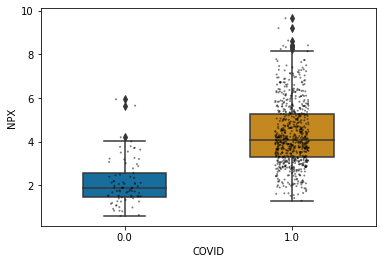

In [32]:
# patient counts by max acuity
feature = "Assay" 
featureVal = "DDX58"
plotFeature = "NPX"
featureData = dataNpx.loc[dataNpx[feature]==featureVal]
print("dimensions: ")
print("    rows: ", featureData.shape[0])
print("    cols: ", featureData.shape[1])
# join on the COVID +/- data from clinical info - join on subject id
joinData = pd.merge(featureData, dataInfo, on='subject_id',how='left')
print("dimensions: ")
print("    rows: ", joinData.shape[0])
print("    cols: ", joinData.shape[1])

bplot = sns.boxplot(y='NPX', x='COVID', 
                 data=joinData, 
                 width=0.5,
                 palette="colorblind")
bplot=sns.stripplot(y='NPX', x='COVID', 
                   data=joinData, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',
                   size=2)
#bplot=sns.swarmplot(y='NPX', x='COVID', 
#                   data=joinData, 
#                   alpha=0.75,
#                   color='black',
#                   size=2)
